### SEGAN without the GAN

Original SEGAN paper: https://arxiv.org/pdf/1703.09452.pdf

In [4]:
import os
import torch
import re
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchaudio import transforms
from data import SpeechDataset
import time
from model import Autoencoder
import pdb
import matplotlib.pyplot as plt
from pypesq import pesq
import torch.nn.functional as F
import torchaudio
from tqdm.notebook import trange, tqdm
from IPython.display import Audio

In [5]:
num_epochs = 100
batch_size = 256
learning_rate = 1e-4

In [6]:
epochs = filter(lambda x: re.search("^seae_epoch_\d+\.pth$", x), os.listdir('models'))
epochs = map(lambda x: int(re.search("^seae_epoch_(\d+)\.pth$", x)[1]), epochs)
last_epoch = max(epochs)

In [7]:
#MODEL_PATH = f'models/seae_epoch_{last_epoch}.pth'

If you'd like to run the training loop, download the OpenSLR12 dataset (http://www.openslr.org/12/), convert all .flac files to .wav and copy to 'data/clean/open_slr'

In [8]:
dataset = SpeechDataset('data/clean/360/', 'data/noise/', window_size=16384, overlap=50, snr=10)

In [9]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
last_epoch = 0

In [11]:
def SDRLoss(output, target):
    output = output.view(-1, 16384)
    target = target.view(-1, 16384)
    
    dot_product = torch.sum(output * target)
    loss = (-1 * dot_product) / (torch.norm(target) * torch.norm(output))
    
    return loss

In [12]:
def weightedSDR(output, target, x):
    noise = x - target
    expected_noise = x - output 
    
    target_norm = torch.norm(target)
    target_norm_sq = target_norm * target_norm
    input_target_norm = torch.norm(x - target)
    input_target_norm_sq = input_target_norm * input_target_norm
    alpha = target_norm_sq / (target_norm_sq + input_target_norm_sq) 
    
    loss = alpha * SDRLoss(output, target) + (1 - alpha) * SDRLoss(noise, expected_noise)
    
    return loss

In [13]:
model = Autoencoder(bs=batch_size).cuda()
#model.load_state_dict(torch.load(MODEL_PATH))
criterion = weightedSDR
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

model.train()

data = next(iter(dataloader))
for epoch in trange(num_epochs):
    #print(f'Starting epoch {epoch + 1 + last_epoch}')
    
    #pbar = tqdm()
    #pbar.reset(total=(len(dataset) // batch_size))
    
    # for i, data in enumerate(dataloader):
    inp = data[0].clone().detach().cuda()
    expected = data[1].clone().detach().cuda()
    output = model(inp)
    loss = criterion(output, expected, inp)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #pbar.update()
    
    #pbar.refresh()
    
    #torch.save(model.state_dict(), f'models/noisy_seae_epoch_{epoch + last_epoch + 1}.pth')
    
    if epoch % 5 == 0:
        print(f'epoch [{epoch}/{num_epochs}]')

        print(round(loss.item(), 5))

epoch [0/100]
-0.03238
epoch [5/100]
-0.45752
epoch [10/100]
-0.78312
epoch [15/100]
-0.84408
epoch [20/100]
-0.86197
epoch [25/100]
-0.87784
epoch [30/100]
-0.88523
epoch [35/100]
-0.89546
epoch [40/100]
-0.89797
epoch [45/100]
-0.89527
epoch [50/100]
-0.91025
epoch [55/100]
-0.91438
epoch [60/100]
-0.91292
epoch [65/100]
-0.91437
epoch [70/100]
-0.9186
epoch [75/100]
-0.91977
epoch [80/100]
-0.92257
epoch [85/100]
-0.92424
epoch [90/100]
-0.92704
epoch [95/100]
-0.92748



In [7]:
# model = Autoencoder(bs=batch_size).cuda()
# model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [1]:
#model

2.7266


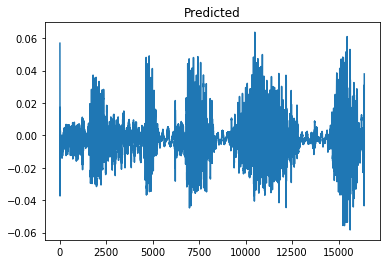

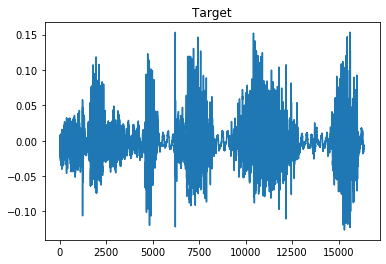

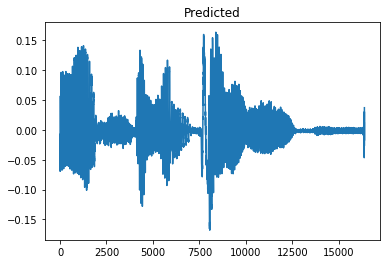

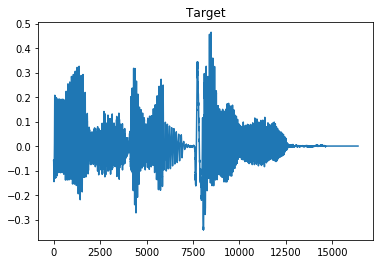

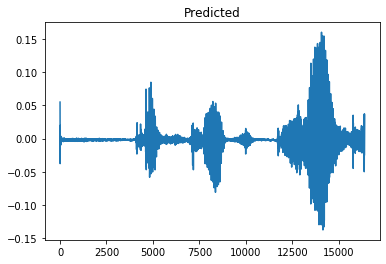

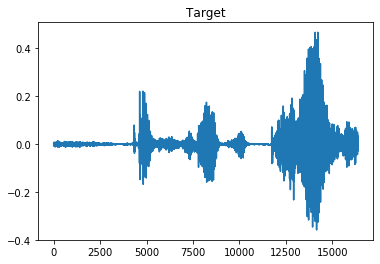

In [15]:
pesqs = []

data = next(iter(dataloader))
model.eval()
with torch.no_grad():
    sample = data[1].cuda()
    
    for i, _s in enumerate(sample[:3]):
        output = model(data[0].cuda())
        ref = output[i, :, :].cpu().detach().numpy().T[:, 0]
        target = sample[i, :, :].cpu().detach().numpy().T[:, 0]
        plt.figure()
        plt.title('Predicted')
        plt.plot(ref)
        plt.figure()
        plt.title('Target')
        plt.plot(target)

        pesqs.append(pesq(target, ref, 16000))
        
print(round(sum(pesqs) / len(pesqs), 4))
Audio(ref, rate=16000)

In [20]:
specgram = torchaudio.transforms.Spectrogram(1024, 300)(ref)
pdb.set_trace()
plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy())


TypeError: 'int' object is not callable

Shape of spectrogram: torch.Size([1, 513, 2461])


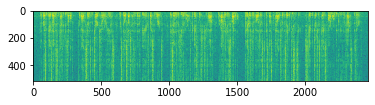